# Main Model for Handwritten Text Synthesis GAN

This model will consist of 4 major networks, following the general architecture of an GAN.

1. Encoder: Produces an embedding that will be concatenated with the noise vector.
2. Generator: Taking noise vector as input and the text embedding to produce an 128x2048 image.
3. Discriminator: Trained alternating with generator input and ground-truth input, binary classification real or fake.
4. Recognizer: Taking image as input, produce a vector representation of the text.

## Import the required libraries:

In [1]:
import csv
import datetime
import os
import random
import re
import requests

import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch_fidelity
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
from torch.nn.utils.spectral_norm import spectral_norm
from torch.utils.data import DataLoader, Dataset, RandomSampler, Subset, random_split
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision import datasets
from torchvision.io import read_image
from torchvision.transforms import Grayscale, Resize, ToTensor, ToPILImage
from torchvision.transforms.functional import InterpolationMode
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

/home/kevin/miniconda3/envs/aps360/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data Loading

### Helper Functions (Run once only to format data)

In [2]:
SCALE_HEIGHT = 32
SCALE_WIDTH = SCALE_HEIGHT*16

def preprocess_lines(data_root):
    """
    Creates a new `.txt` file `lines_improved.txt` that will be used
    for querying. This new `.txt` file contains all info necessary
    for the functionality of this project.
    """

    original_path = os.path.join(data_root, "lines.txt")
    improved_path = os.path.join(data_root, "lines_improved.txt")
    fi = open(improved_path, "w")

    # Some variables for tracking
    num_samples = 0
    valid_samples = 0
    
    # Loop through "lines.txt"
    with open(original_path, "r") as fo:
        headers = ["image_id", "image_path", "image_pt_path", "graylevel", "original_height", "original_width", "transcription", "transcription_len"]

        # First write the headers at the top of the file
        fi.writelines("\t".join(headers) + "\n")

        # Skip the intro stuff
        for line in fo.readlines():
            if line.startswith("#"):
                continue

            # Valid lines, not the intro_text
            line_items = line.strip().split(" ")  # `strip()` to remove newlines

            # The actual items (we extract the important ones)
            image_id = line_items[0]
            status = line_items[1]
            graylevel = int(line_items[2])
            transcription = " ".join(line_items[8:])  # Some data has whitespace, we join string till the end

            # Skip error images
            if status == "err":
                continue
        
            # Alphanumeric + common punctuation regex
            # Returns None if no match
            # 26 + 26 + 10 + 9 + 1 = 72
            # Spaces might be included as well
            # Punctuation include , ! ? ' " , : ; -
            if re.fullmatch("[a-zA-Z0-9.!?'\",:;| -]*", transcription) is None:
                continue

            # Now we have valid transcription
            num_samples += 1

            # We get the `.png` image path
            inp = image_id.split("-")  # `inp` stands for image name parts
            image_path_head = os.path.join(data_root, "lines", inp[0], f"{inp[0]}-{inp[1]}")
            image_path_tail = f"{image_id}.png"
            image_path = os.path.join(image_path_head, image_path_tail)
            
            # Read image, gets its dimensions, perform processing operations, and other stuff
            tmp_image = cv.imread(os.path.join(image_path_head, image_path_tail), cv.IMREAD_GRAYSCALE)  # Removes the channel dimension
            height, width = tmp_image.shape

            # Scaling calculations
            # If width * scale >= desired length (>= to be safe)
            # Condition here to speed up overall processing time
            if width * (SCALE_HEIGHT/height) >= SCALE_WIDTH:
                continue

            resized_tensor = process_image(tmp_image, graylevel)
            image_pt_path = os.path.join(image_path_head, f"{image_id}.pt")
            torch.save(resized_tensor, image_pt_path)

            # A fully valid image
            # Separate by underscores because `transcription` has spaces so we can't split by spaces
            fi.writelines(f"{image_id}\t{image_path}\t{image_pt_path}\t{graylevel}\t{height}\t{width}\t{transcription}\t{len(transcription)}\n")
            valid_samples += 1
        
        fi.close()
    
    print("# samples:", num_samples)
    print("Valid samples:", valid_samples)


def process_image(cv_image, graylevel):
    """
    Takes in a grayscale image that OpenCV read of shape (H, W) of type uint8
    Returns a PyTorch tensor of shape (1, 32, W'), where W' is the scaled width
    This tensor is padded and effectively thresholded
    """

    # Scaling factor
    height, width = cv_image.shape
    scale = SCALE_HEIGHT/height
    scaled_width = int(width*scale)

    # Trick here is to apply threshold before resize and padding
    # This allows OpenCV resizing to create a cleaner output image
    # 2nd return value is the thresholded image
    output = cv.threshold(cv_image, graylevel, 255, cv.THRESH_BINARY)[1]

    # INTER_AREA recommended for sizing down
    output = cv.resize(output, (scaled_width, SCALE_HEIGHT), interpolation=cv.INTER_AREA)

    # Turn it back to a tensor and map to [0, 1]
    output = torch.from_numpy(output).unsqueeze(0).type(torch.float32)
    output = (output-output.min()) / (output.max()-output.min())
    
    # Add padding
    _, _, resized_height = output.shape
    padding_to_add = SCALE_WIDTH - resized_height
    output = F.pad(output, (0, padding_to_add), value=1.0)

    return output

# Uncomment this if your data isn't processed yet
# preprocess_lines("./data/")

### Important Dict (Run everytime before training)

In [3]:
# Sorted by ascii code
valid = [
    ' ', '!', '"', "'", ',', '-', '.',
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
    ':', ';', '?', 
    'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'
]
# Enumerate from 1 to save space for padding
# Reserve 0 for CTC blank
char_to_int = {v: i for i, v in enumerate(valid, 1)}
int_to_char = {i: v for i, v in enumerate(valid, 1)}

In [4]:
class LineDataset(Dataset):
    def __init__(self, lines_improved_dir, ty=None):
        """
        params:
            lines_improved_dir: path to the `lines_improved.txt` file
            ty: type of the dataset "txt", "img" for text dataset or image dataset.
        """
        
        # Dataframe containing the stuff in `lines_improved.txt`
        self.lines_df = pd.read_csv(lines_improved_dir, sep="\t", quoting=csv.QUOTE_NONE)

        # Class properties
        self.ty = ty  # Type of dataset (lines, images, or both)
        self.max_transcription_len = max(self.lines_df["transcription_len"])

        # Temp variables...
        length = self.lines_df.shape[0]
        line_datas = self.lines_df.iloc
        ret_texts = [line_datas[i]["transcription"].replace('|', ' ') for i in range(length)]
        ret_ctois = [torch.tensor([char_to_int[char] for char in ret_texts[i]]) for i in range(length)]

        # ...for the important data
        if self.ty in ("txt", None):  # Added this condition to speed thigns up if only text
            self.ret_ctoi_paddeds = [F.pad(ret_ctois[i], pad=(0, self.max_transcription_len-len(ret_ctois[i])), value=0) for i in range(length)]
        if self.ty in ("img", None):
            self.ret_images = [torch.load(line_datas[i]["image_pt_path"]) for i in range(length)]

    def __len__(self):
        return len(self.lines_df)
    
    def __getitem__(self, index):
        # Different type of individual loaders
        if self.ty == "txt":
            return self.ret_ctoi_paddeds[index]
        elif self.ty == "img":
            return self.ret_images[index]
        else:
            return self.ret_images[index], self.ret_ctoi_paddeds[index]

In [5]:
line_transcription_dataset = LineDataset("./data/lines_improved.txt", ty="txt")
line_image_dataset = LineDataset("./data/lines_improved.txt", ty="img")
line_dataset = LineDataset("./data/lines_improved.txt")

# Don't change this, we want to maintain consistent split
torch.manual_seed(12345678)  # DO NOT REMOVE THIS LINE
line_transcription_dataset_train, line_transcription_dataset_val = random_split(line_transcription_dataset, [0.8, 0.2])
line_image_dataset_train, line_image_dataset_val = random_split(line_image_dataset, [0.8, 0.2])
line_dataset_train, line_dataset_val = random_split(line_dataset, [0.8, 0.2])

# To train on a small dataset
line_transcription_dataset_train = Subset(line_transcription_dataset_train, range(20))
line_transcription_dataset_val = Subset(line_transcription_dataset_val, range(10))

line_image_dataset_train = Subset(line_image_dataset_train, range(20))
line_image_dataset_val = Subset(line_image_dataset_val, range(10))

line_dataset_train = Subset(line_dataset_train, range(1000))
line_dataset_val = Subset(line_dataset_val, range(10))

# line_transcription_dataset_train, line_transcription_dataset_val, _ = random_split(line_transcription_dataset, [0.005, 0.005, 0.99])
# line_image_dataset_train, line_image_dataset_val, _ = random_split(line_image_dataset, [0.005, 0.005, 0.99])
# line_dataset_train, line_dataset_val = random_split(line_dataset, [0.0025, 0.9975])

print("lines")
print(len(line_transcription_dataset_train), len(line_transcription_dataset_val))
print("images")
print(len(line_image_dataset_train), len(line_image_dataset_val))
print("both")
print(len(line_dataset_train), len(line_dataset_val))


lines
20 10
images
20 10
both
1000 10


torch.Size([1, 32, 512])
torch.Size([32, 512])
tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])


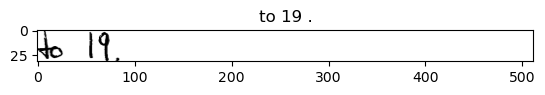

In [6]:
image, label = line_dataset_train[0]
print(image.shape)
plt.title("".join([int_to_char[int(val)] for val in label[label.nonzero()]]))
print(image.squeeze(0).shape)
plt.imshow(image.squeeze(0), cmap='gray')
label, "".join([int_to_char[int(val)] for val in label[label.nonzero()]])
# line_dataset.lines_df.iloc[798]
print(image)

Define Key Functions

In [27]:
def train(recognizer, 
              train_line_dataset, val_line_dataset, 
              batch_size=64, recognizer_lr=1e-5,
              betas=(0, 0.999), num_epochs=30, loss_balancing_alpha=1):
    # Note, the generator and discriminator should be spectrally normalized before training
    # TODO: load dataloader with batch size batch_size

    device = torch.device('cpu' if torch.cuda.is_available() else 'cpu')
    # device = torch.device('cpu')
    print(device)
    recognizer = recognizer.to(device)
    
    train_line_dataset_loader = DataLoader(train_line_dataset, batch_size=batch_size, shuffle=True)
    val_line_dataset_loader = DataLoader(val_line_dataset, batch_size=batch_size, shuffle=True)

    recognizer_optimizer = optim.Adam(recognizer.parameters(), lr=recognizer_lr)
    
    recognizer_loss_function = nn.CTCLoss(reduction='sum', zero_infinity=True)
    torch.nn.utils.clip_grad_norm_(recognizer.parameters(), max_norm=0.5)
    recognizer_train_losses = []
    recognizer_train_accuracies = []
    recognizer_val_losses = []
    recognizer_val_accuracies = []

    for epoch in range(num_epochs):
        display_images = []

        recognizer_train_loss = 0
        recognizer_train_accuracy = 0

        for i, (line_image_batch, line_text_batch) in enumerate(train_line_dataset_loader):
#             print("epoch", epoch, "batch", i)
#             print("line_image_batch.shape", line_image_batch.shape)
            cur_batch_size, _ = line_text_batch.shape
#             print("line_text_batch.shape", line_text_batch.shape)
            test = line_text_batch[0]
            test = test[test.nonzero()]
            test = "".join([int_to_char[int(i)] for i in test])
            print("\t",test)
            print(line_text_batch.shape)
            line_image_batch = line_image_batch.to(device)
            line_text_batch = line_text_batch.to(device)
            plt.imshow(line_image_batch[0].cpu().squeeze(0), cmap='gray')
            recognizer_outputs = recognizer(line_image_batch)

#             test2 = "".join([int_to_char[int(i)] for i in test2])

#             Refer to CTC documentation
            line_text_batch_pad_remove = [line_text[line_text.nonzero().squeeze(1)] for line_text in line_text_batch]  # Array of tensors
            target_lengths = torch.tensor([len(line_text_pad_remove) for line_text_pad_remove in line_text_batch_pad_remove])
            target = torch.cat(line_text_batch_pad_remove)
            input_lengths = torch.full(size=(cur_batch_size,), fill_value=2*82+1)
            recognizer_loss = recognizer_loss_function(
                recognizer_outputs.log_softmax(2),
                target,
                input_lengths,
                target_lengths
            )
            test2 = recognizer_outputs[:,0,:]
#             print(test2)
            test2 = torch.softmax(test2, dim=1)
#             print(test2)
            test2 = torch.argmax(test2, dim=1)
#             print(test2.shape)
            test2 = test2[test2.nonzero()]
#             print(test2.shape)
#             test2 = test2[test2.nonzero()]
            test2 = "".join([int_to_char[int(i)] for i in test2])
            
            print(f"_{test2}_")

            recognizer_loss.backward()
            recognizer_optimizer.step()
            print(recognizer_loss)
            # recognizer_train_loss += recognizer_loss
        
        recognizer_val_loss = 9999

        print(f"Epoch {epoch}")

## Define Network Classes

### Define Main Networks

In [28]:
class Recognizer(nn.Module):
    """
    RNN:
    Input with a N x 1 x 32 x 512 image
    Output a vector representation of the text size N x 73 x (82*2+1)
    Purpose is to recognize the text from the image, to encourage the generator to produce images that are representations of the text
    """
    
    def __init__(self):
        super().__init__()
        self.name = "recognizer"
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), stride=2),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3)),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=2),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=2*82+1, kernel_size=(3, 3)),
            nn.BatchNorm2d(2*82+1),
            nn.LeakyReLU()
        )
        # Batch first is false to make it easier for CTC loss
        self.rnn = nn.GRU(input_size=496, hidden_size=256, bidirectional=True, num_layers=5, batch_first=True)
        self.final = nn.Linear(256*2, 73)
        
    def forward(self, img):
        '''
        torch.Size([32, 1, 32, 512])
        torch.Size([32, 256, 8, 128])
        torch.Size([32, 256, 1024])
        torch.Size([32, 165, 256])
        torch.Size([32, 165, 256])
        torch.Size([32, 165, 73])
        torch.Size([165, 32, 73])
        '''
        
        bs, _, _, _ = img.shape
        # Encode it with CNNs
        img = self.encoder(img)
        # Next flatten but keep it in a form to be fed into the RNN
        img = img.view(bs, img.size(1), -1)
        # FC gets the 2*82+1 sequence length
        img, _ = self.rnn(img)
        # Pass it through a final FC layer
        img = self.final(img)
        # Change to (T, N, C)
        img = img.permute(1, 0, 2)
        print(img.shape)
        # No sigmoid because CTC loss requires `log_softmax`
        return img
        
        
recog = Recognizer()
recog(torch.randn((32, 1, 32, 512), dtype=torch.float32))
None
# print(recog)
    # TODO: http://www.tbluche.com/files/icdar17_gnn.pdf use "big architecture"

torch.Size([165, 32, 73])


## Significant Hyperparameters to Tune
- Dimension of text embedding, we can start with 128, 256, or 512 and increase it later on.
- Dataset of training. If the model does not converge, it is likely we will have to manually select example images that have similar writing style.
- Learning rate
- Balancing the effect of recognizer and discriminator

- Generator Networks:
  - ResNetUp
    - Should the bias be False? Or can it be True?
      - conv1 probably don't, since it is batch-normalized right after
      - but what about conv2?
  - Conditional Batch Norm
  - Number of filters in each resnet block

LSTM hidden layers should increase, hidden size should increase. 
- because our text is longer. 

- Discriminator Networks:
  - ResNetDown
    - Still if bias should be False?
    - LeakyReLU slope
  - ResNet
    - bias?
    - leakyReLU slope



cpu
	 The details are harder still to see .
torch.Size([64, 82])
torch.Size([165, 64, 73])
_YDDDUUUUUUUUUUUUUUUUwwwwwwwwwwUDDUUUUUUwwwwwwwwwwwwwwwUUUUUwwwwGGGGGGGGwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwwUUUUwwwwwwwwwwwwwwwwwwwwwwwwwwwwww_
tensor(37040.3203, grad_fn=<SumBackward0>)
	 sunshine , still burning like a half-cooled iron ,
torch.Size([64, 82])
torch.Size([165, 64, 73])
_qqqqqqqqqqqqhhhhhhhhhqqqqqqqqGqqqqq;qqqqqqqqqDDGGGqqqwwqqqqqqqqqqGGGGGGGwwwqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqqDDqqqqqqqqqqqqqqqqqqqqqqqqhhhqqqqqqqqqqqqqqqqqqqwwwwwwwwwww_
tensor(36805.2852, grad_fn=<SumBackward0>)
	 from any point of view .
torch.Size([64, 82])
torch.Size([165, 64, 73])
_I2222GGGGGG22gg2222222;;22222222222222wwwwwww22qqqqqqqq2222222222wwwwwwwww22222wwwwww22222222222qqqq2222222222222222222cc2qqqqq222222222222222222222222222wGGwwwwwwww_
tensor(36716.8672, grad_fn=<SumBackward0>)
	 as ' more like a God upon earth than a human
torch.Size([64, 82])
torch.Size([165, 64, 73])
_bbbUUUw

KeyboardInterrupt: 

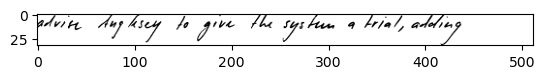

In [29]:
recognizer = Recognizer()
# generator = load_model(generator, "main_model/model_snapshots/2023-07-13_18-06-43_bs4_lr0.0002_betas(0, 0.999)_generator_epoch9.pt")
# generator, encoder, discriminator = load_models_of_same_batch(generator, encoder, discriminator, filename_prefix="main_model/model_snapshots/2023-07-13_18-06-43_bs4_lr0.0002_betas(0, 0.999)", epoch_number=9)

train(recognizer=recognizer, 
              train_line_dataset=line_dataset_train, val_line_dataset=line_dataset_val, 
              batch_size=64, recognizer_lr=0.00001,
              betas=(0, 0.999), num_epochs=30, loss_balancing_alpha=1)